In [2]:
# ONLY HAS TO BE RUN ONCE TO EXPORT DATASET FROM ZIP TO FOLDER
import zipfile

zip_path = "Resources.zip" 
extract_to = "Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [4]:
## ALL FUNCTION NEEDED TO TRAIN AND VALIDATE MODEL (Has to be run before any code segment)
import os
import shutil
data_path_train = "Dataset/new_training"
data_path_valid = "Dataset/new_validation"
data_path_test = "Dataset/testing"

import glob
import nibabel as nib
import numpy as np
import monai
import torch.nn.functional as F
from medpy.metric.binary import hd, dc

import time
import torch

from monai.data import CacheDataset, DataLoader
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

from monai.transforms import (
    Compose,
    Lambda,
    LoadImaged,         # if using file paths
    AddChanneld,        # ensures channel-first format
    ScaleIntensityd,    # normalizes intensity to [minv, maxv]
    Spacingd,           # resamples to a uniform voxel spacing
    ResizeWithPadOrCropd,  # resizes images/masks to a fixed spatial size
    EnsureTyped,        # converts arrays to PyTorch tensors
    RandZoomd,          # random zoom augmentation
    RandFlipd,          # random flip augmentation
    RandRotated,        # random rotation augmentation
    RandShiftIntensityd # random intensity shift for brightness variation
)

# Start up wandb and start logging
import wandb



print("Done Importing!")

def get_ed_es_frames(config_path):
    """Extract ED and ES frame numbers from the info.cfg file."""

    ed_frame, es_frame = None, None
    with open(config_path, 'r') as f:
        for line in f:
            if line.startswith('ED:'):
                ed_frame = int(line.split(':')[1].strip())
            elif line.startswith('ES:'):
                es_frame = int(line.split(':')[1].strip())
    return ed_frame, es_frame


def build_dict_acdc(data_path, mode='train'):
    """
    This function returns a list of dictionaries, each containing the paths to the 2D slices 
    of the 3D MRI images and their corresponding masks.
    """
    if mode not in ["train", "val", "test"]:
        raise ValueError(f"Please choose a mode in ['train', 'val', 'test']. Current mode is {mode}.")
    
    dicts = []
    
    # Loop over all patient directories
    patient_dirs = [d for d in glob.glob(os.path.join(data_path, '*')) if os.path.isdir(d)]
    
    for patient_dir in patient_dirs:
        patient_id = os.path.basename(patient_dir)
        config_path = os.path.join(patient_dir, "Info.cfg")
        
        if not os.path.exists(config_path):
            continue
        
        ed_frame, es_frame = get_ed_es_frames(config_path)
        
        # Identify the ED and ES image and mask paths
        ed_img_path = os.path.join(patient_dir, f"{patient_id}_frame{ed_frame:02d}.nii.gz")
        ed_mask_path = os.path.join(patient_dir, f"{patient_id}_frame{ed_frame:02d}_gt.nii.gz")
        es_img_path = os.path.join(patient_dir, f"{patient_id}_frame{es_frame:02d}.nii.gz")
        es_mask_path = os.path.join(patient_dir, f"{patient_id}_frame{es_frame:02d}_gt.nii.gz")
        
        for img_path, mask_path in [(ed_img_path, ed_mask_path), (es_img_path, es_mask_path)]:
            if not os.path.exists(img_path) or not os.path.exists(mask_path):
                continue
            
            # Load the 3D image and mask using nibabel
            img_volume = nib.load(img_path).get_fdata()
            mask_volume = nib.load(mask_path).get_fdata()
            #print("Unique values in loaded ground truth mask:", np.unique(mask_volume))
            
            # Ensure we have the same number of slices for image and mask
            num_slices = img_volume.shape[2]
            
            # Extract 2D slices
            for slice_idx in range(num_slices):
                img_slice = img_volume[:, :, slice_idx]
                mask_slice = mask_volume[:, :, slice_idx]
                
                dicts.append({'img': img_slice, 'mask': mask_slice})
    
    return dicts

class LoadHeartData(monai.transforms.Transform):
    """
    This custom Monai transform loads 2D slices of MRI data and their corresponding mask for heart segmentation.
    """
    def __init__(self, keys=None):
        pass
    
    def __call__(self, sample):
        img_slice = sample['img']
        mask_slice = sample['mask'] 
        
        # Ensure the image and mask are in compatible formats
        img_slice = np.array(img_slice, dtype=np.float32)
        mask_slice = np.array(mask_slice, dtype=np.uint8) 
        
        # Return the slice and mask with metadata. NOT SURE ABOUT THE METATDATA
        return {'img': img_slice, 'mask': mask_slice, 'img_meta_dict': {'affine': np.eye(2)}, 
                'mask_meta_dict': {'affine': np.eye(2)}}

HEADER = ["Name", "Dice LV", "Volume LV", "Err LV(ml)",
          "Dice RV", "Volume RV", "Err RV(ml)",
          "Dice MYO", "Volume MYO", "Err MYO(ml)"]

#
# Functions to process files, directories and metrics aka loss function
#
def metrics(img_gt, img_pred, voxel_size):
    """
    Function to compute the metrics between two segmentation maps given as input.

    Parameters
    ----------
    img_gt: np.array
    Array of the ground truth segmentation map.

    img_pred: np.array
    Array of the predicted segmentation map.

    voxel_size: list, tuple or np.array
    The size of a voxel of the images used to compute the volumes.

    Return
    ------
    A list of metrics in this order, [Dice LV, Volume LV, Err LV(ml),
    Dice RV, Volume RV, Err RV(ml), Dice MYO, Volume MYO, Err MYO(ml)]
    """

    if img_gt.ndim != img_pred.ndim:
        raise ValueError("The arrays 'img_gt' and 'img_pred' should have the "
                         "same dimension, {} against {}".format(img_gt.ndim,
                                                                img_pred.ndim))
    #print("Unique values in ground truth:", np.unique(img_gt))
    #print("Unique values in prediction:", np.unique(img_pred))
    
    res = []
    # Loop on each classes of the input images
    for c in [3, 1, 2]:
        # Copy the gt image to not alterate the input
        gt_c_i = np.copy(img_gt)
        gt_c_i[gt_c_i != c] = 0

        # Copy the pred image to not alterate the input
        pred_c_i = np.copy(img_pred)
        pred_c_i[pred_c_i != c] = 0

        # Clip the value to compute the volumes
        gt_c_i = np.clip(gt_c_i, 0, 1)
        pred_c_i = np.clip(pred_c_i, 0, 1)

        # Compute the Dice
        dice = dc(gt_c_i, pred_c_i)

        # Compute volume
        volpred = pred_c_i.sum() * np.prod(voxel_size) / 1000.
        volgt = gt_c_i.sum() * np.prod(voxel_size) / 1000.

        res += [dice, volpred, volpred-volgt]

    return res

def compute_metrics_on_files(path_gt, path_pred):
    """
    Function to give the metrics for two files

    Parameters
    ----------

    path_gt: string
    Path of the ground truth image.

    path_pred: string
    Path of the predicted image.
    """
    gt, _, header = load_nii(path_gt)
    pred, _, _ = load_nii(path_pred)
    zooms = header.get_zooms()

    name = os.path.basename(path_gt)
    name = name.split('.')[0]
    res = metrics(gt, pred, zooms)
    res = ["{:.3f}".format(r) for r in res]

    formatting = "{:>14}, {:>7}, {:>9}, {:>10}, {:>7}, {:>9}, {:>10}, {:>8}, {:>10}, {:>11}"
    print(formatting.format(*HEADER))
    print(formatting.format(name, *res))

    
# Note that this is a clear, but slow way to do this, we might be better off with a quick hardcode since the patients are ordered anyways.
# So technically, the first 20 of train is just group DCM and we dont need to make any folders or copy any files.
# this could also be sped up by moving per patient and not per file per patient (the last loop)
# DOOR ERIC        
# Recombine into a training and a validation set (set 1 to validation and 4 to training)
def recombining_data(recombine_index):
    
    new_train_path = os.path.join("Dataset", 'new_training')
    new_val_path = os.path.join("Dataset", 'new_validation')
    
    # If folder does not exist yet
    if not os.path.exists(new_train_path):
        os.makedirs(new_train_path)  # Creates the new training folder
    if not os.path.exists(new_val_path):
        os.makedirs(new_val_path)  # Creates the new validation folder
    
    
    # Empty the new_validation folder
    if os.path.exists(new_val_path):
        shutil.rmtree(new_val_path)
        os.makedirs(new_val_path)

    # Empty the new_training folder
    if os.path.exists(new_train_path):
        shutil.rmtree(new_train_path)
        os.makedirs(new_train_path)
    
   
    val_id = [1,2,3,4]
    offset = (recombine_index - 1) * 4
    val_id = [element + offset for element in val_id] # Add the offset to each element of val_id
    #print(val_id)
    
    train_id = list(range(1,21))
    for element in val_id:
        train_id.remove(element) # remove the validation patients
    #print(train_id)
    
    # now there is a list of numbers for who should be in val, and who should be in train
    
    # Define the classes (group folders) you want to loop through
    class_folders = ['group_DCM', 'group_HCM', 'group_MINF', 'group_NOR', 'group_RV']
    
    # Loop through each class folder
    for class_folder in class_folders:
        class_folder_path = os.path.join("Dataset", class_folder)
        
        patients_in_class = [folder for folder in os.listdir(class_folder_path)] # list of all file names in class
        
        for val_target in val_id: # copy all validation patients
            val_patient_target = patients_in_class[val_target - 1] # get name of validation patient
            #print(f"Processing validation patient: {val_patient_target}")
            
            # copy from source to destination
            source_folder = os.path.join("Dataset", class_folder,val_patient_target)
            destination_folder = os.path.join(new_val_path, val_patient_target)
            shutil.copytree(source_folder, destination_folder)
            
        for train_target in train_id: # copy all training patients
            train_patient_target = patients_in_class[train_target - 1] # get name of training patient
            #print(f"Processing training patient: {train_patient_target}")
            
            # copy from source to destination
            source_folder = os.path.join("Dataset", class_folder,train_patient_target)
            destination_folder = os.path.join(new_train_path, train_patient_target)
            shutil.copytree(source_folder, destination_folder)


Done Importing!


/home/jovyan/new_python_3_11_env/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)
Loading dataset: 100%|██████████| 1076/1076 [00:10<00:00, 99.28it/s]


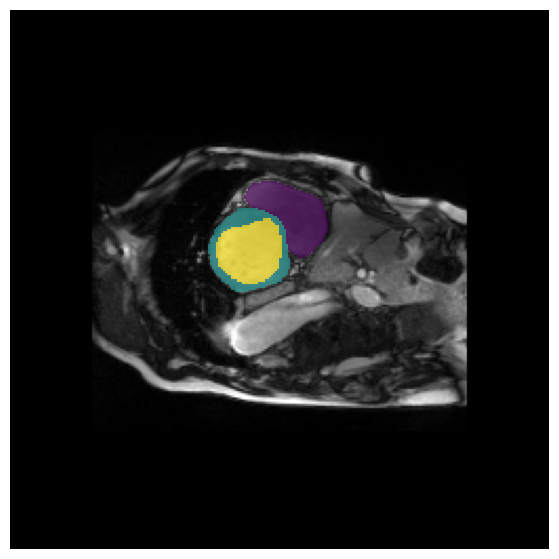

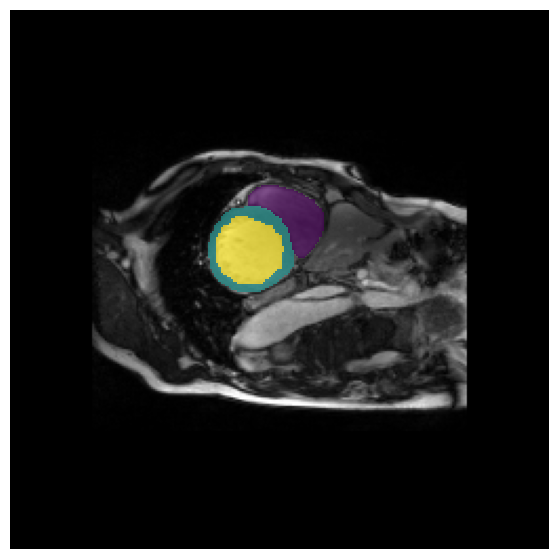

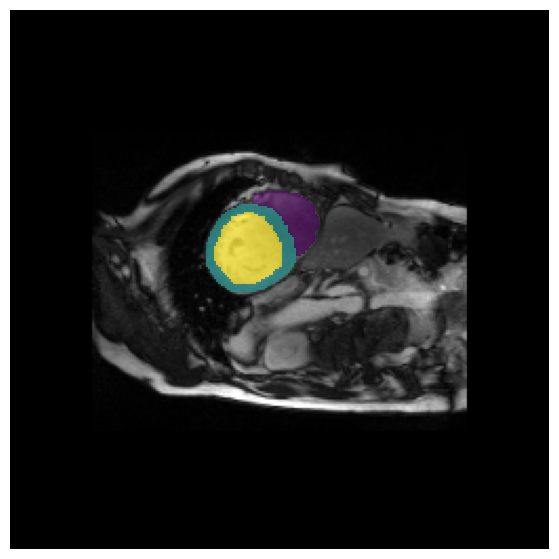

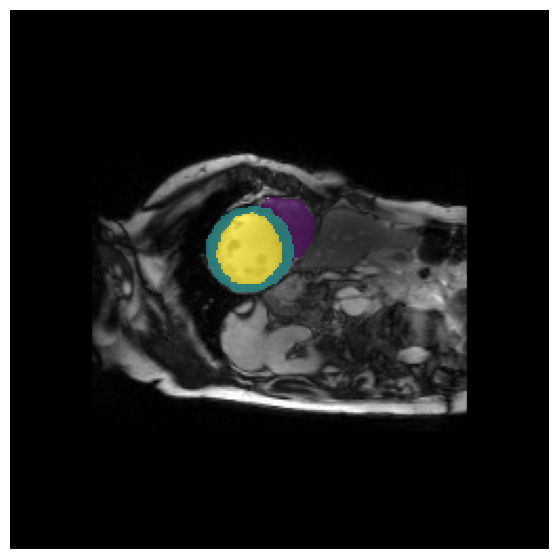

In [3]:

import matplotlib.pyplot as plt
import numpy as np

# Define a common preprocessing pipeline
common_transform = Compose([
    LoadHeartData(),  
    AddChanneld(keys=["img", "mask"]), # Add channel dimension
    ScaleIntensityd(keys=["img"], minv=0, maxv=1),  # Normalize intensity
    Spacingd(keys=["img", "mask"], pixdim=(1.25, 1.25), mode=("bilinear", "nearest")), # Resample voxel spacing in x and y
    # Resized(keys=["img", "mask"], spatial_size=(256, 256), mode=("area", "nearest")),
    ResizeWithPadOrCropd(keys=["img", "mask"], spatial_size=[256, 256]), # Ensures all images have the same dimensions (without getting stretched out). 
    EnsureTyped(keys=["img", "mask"])
])
    
test_transforms = common_transform

test_dataset = CacheDataset(
        data=build_dict_acdc(data_path_test, mode='test'),
        transform=test_transforms
    )

def visualize_heart_sample(sample, title=None):
    """
    Visualize the MRI image of the heart and overlay the segmentation mask on top of it.
    """
    # Get the image and mask from the sample
    image = np.squeeze(sample['img'])
    mask = np.squeeze(sample['mask'])
    
    # Create the plot
    plt.figure(figsize=[10,7])
    
    # Display the MRI image in grayscale
    plt.imshow(image, cmap='gray')
    
    # Overlay the mask 
    overlay_mask = np.ma.masked_where(mask == 0, mask)  # Mask out the background
    
    # Overlay the mask on top of the image
    plt.imshow(overlay_mask, alpha=0.7, interpolation='nearest') # Not needed to use clim[0,1] because the mask is not binary in this case
    
    # Optionally set a title
    if title is not None:
        plt.title(title)
    
    plt.axis('off')
    plt.show()

    # Visualize samples from the training set
for i in range(4):
    sample = test_dataset[i]
    visualize_heart_sample(sample)

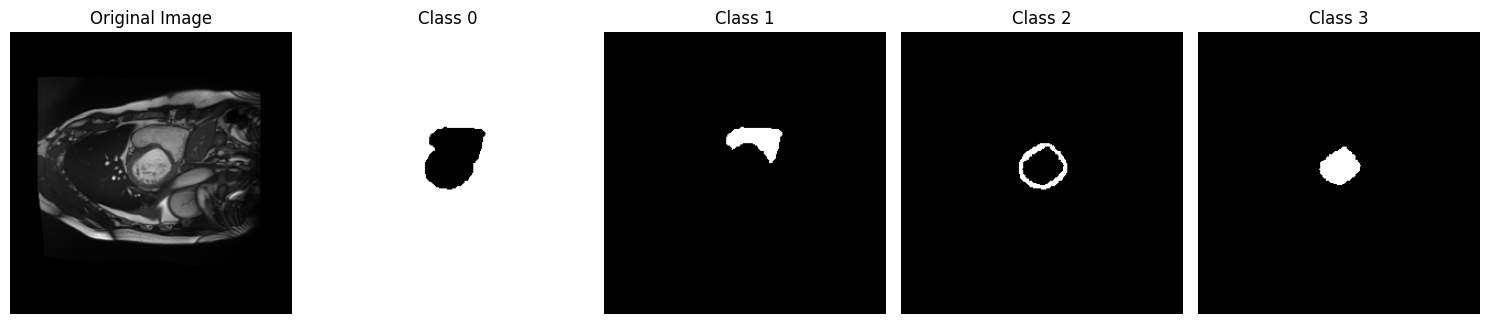

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Define a common preprocessing pipeline
common_transform = Compose([
    LoadHeartData(),  
    AddChanneld(keys=["img", "mask"]), # Add channel dimension
    ScaleIntensityd(keys=["img"], minv=0, maxv=1),  # Normalize intensity
    Spacingd(keys=["img", "mask"], pixdim=(1.25, 1.25), mode=("bilinear", "nearest")), # Resample voxel spacing in x and y
    # Resized(keys=["img", "mask"], spatial_size=(256, 256), mode=("area", "nearest")),
    ResizeWithPadOrCropd(keys=["img", "mask"], spatial_size=[256, 256]), # Ensures all images have the same dimensions (without getting stretched out). 
    EnsureTyped(keys=["img", "mask"])
])
    
test_transforms = common_transform

test_dataset = CacheDataset(
        data=build_dict_acdc(data_path_test, mode='test'),
        transform=test_transforms
    )

# Select a sample to visualize
sample_idx = 1  # Change this index to visualize different samples

# Load the sample
sample = test_dataset[sample_idx]
img = sample["img"].squeeze()  # Remove channel dimension if necessary
mask = sample["mask"].squeeze()

# Create a figure with subplots: 1 for the image + 4 for the class masks
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# Plot the original grayscale image
axes[0].imshow(img, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# Generate binary masks for each class (0, 1, 2, 3)
for i in range(4):  # Iterate over all classes
    class_mask = (mask == i).astype(np.float32)  # Binary mask for class i (black/white)
    axes[i + 1].imshow(class_mask, cmap="gray")  # Black and white colormap
    axes[i + 1].set_title(f"Class {i}")
    axes[i + 1].axis("off")

plt.tight_layout()
plt.show()


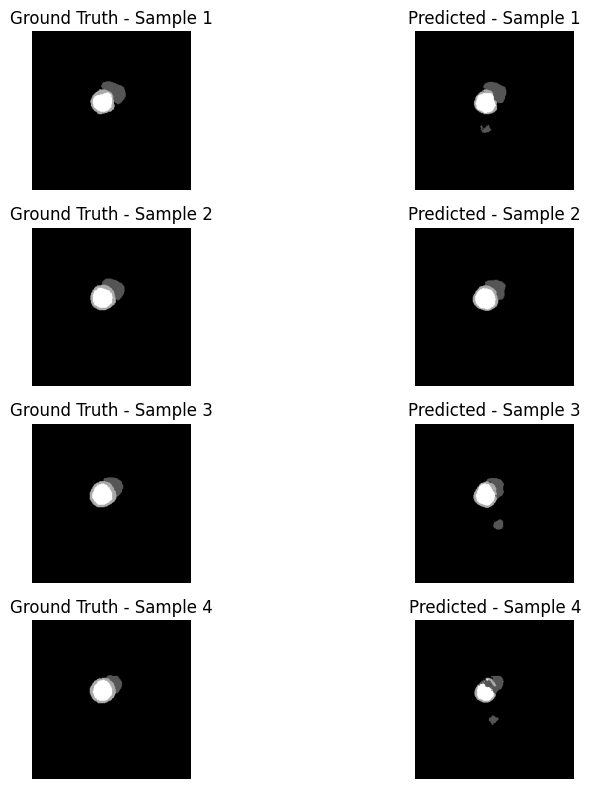

In [29]:
# Visualize multiple predicted and ground truth masks
val_data = next(iter(test_loader))  # Grab a sample from the test_loader
val_inputs = val_data["img"].to(device)
val_labels = val_data["mask"].squeeze(1).to(device)
val_outputs = model(val_inputs)

# Get predicted classes (output from the model)
pred_classes = torch.argmax(torch.softmax(val_outputs, dim=1), dim=1)

# Number of images to display
num_images = 4  # Adjust this value to show the desired number of images

# Set up the plot
fig, axes = plt.subplots(num_images, 2, figsize=(10, 2 * num_images))

# Loop through the images in the batch 
for i in range(num_images):
    # Plot ground truth mask
    axes[i, 0].imshow(val_labels[i].cpu().numpy(), cmap='gray')
    axes[i, 0].set_title(f"Ground Truth - Sample {i + 1}")
    axes[i, 0].axis('off')  # Hide axes for cleaner display
    
    # Plot predicted mask
    axes[i, 1].imshow(pred_classes[i].cpu().numpy(), cmap='gray')
    axes[i, 1].set_title(f"Predicted - Sample {i + 1}")
    axes[i, 1].axis('off')  # Hide axes for cleaner display

# Adjust spacing between images
plt.tight_layout()
plt.show()


In [48]:
import zipfile

zip_path = "PreProc_BasicUNet_Cross_validation_NoCommonTransform_100_models.zip" 
extract_to = "bad_models"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [8]:
# THIS CODE SEGMENT WILL LOAD IN A TEST DATASET AND A SPECIFIC MODEL and put into the datasets the according masks
import os
import nibabel as nib
import numpy as np
import torch
from monai.networks.nets import UNet
from skimage.transform import resize
import matplotlib.pyplot as plt


#############################################
# Helper: Crop or pad a 2D slice to a target shape
#############################################
def crop_or_pad_slice(slice_img, target_shape):
    """
    Adjusts a 2D slice to the target shape by center-cropping if the slice is larger,
    or center-padding if it is smaller.
    
    Parameters:
      slice_img: 2D numpy array.
      target_shape: tuple (target_height, target_width).
      
    Returns:
      A 2D array of shape target_shape.
    """
    current_h, current_w = slice_img.shape
    target_h, target_w = target_shape

    # Calculate differences for height and width
    diff_h = target_h - current_h
    diff_w = target_w - current_w

    # For height: if padding is needed, split the extra pixels evenly.
    if diff_h > 0:
        pad_top = diff_h // 2
        pad_bottom = diff_h - pad_top  # This ensures symmetry even if diff_h is odd.
        slice_img = np.pad(slice_img, ((pad_top, pad_bottom), (0, 0)), mode='constant')
    elif diff_h < 0:
        # Crop evenly from top and bottom
        crop_top = (-diff_h) // 2
        crop_bottom = (-diff_h) - crop_top
        slice_img = slice_img[crop_top: current_h - crop_bottom, :]

    # For width:
    current_h, current_w = slice_img.shape  # update width after height adjustments
    if diff_w > 0:
        pad_left = diff_w // 2
        pad_right = diff_w - pad_left
        slice_img = np.pad(slice_img, ((0, 0), (pad_left, pad_right)), mode='constant')
    elif diff_w < 0:
        crop_left = (-diff_w) // 2
        crop_right = (-diff_w) - crop_left
        slice_img = slice_img[:, crop_left: current_w - crop_right]

    return slice_img


#############################################
# Function that loads in the model
#############################################
def load_model(model_path, device):
    """
    Loads a saved UNet model from model_path and returns the model in eval mode.
    Adjust the architecture parameters as necessary.
    """
    #FOR 64 BASED MODEL
    model = UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=4,
        channels=(64, 128, 256, 512, 1024),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)
    # FOR BASIC MODEL
    #model = UNet(
    #    spatial_dims=2,
    #    in_channels=1,
    #    out_channels=4,
    #    channels=(16, 32, 64, 128, 256),
    #    strides=(2, 2, 2, 2),
    #    num_res_units=2,
    #).to(device)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

##########################################################################
# Function that loads in a test nii.gz file and returns original info
##########################################################################
def load_test_nii(file_path):
    """
    Loads a test NIfTI file and returns:
    - image data as a numpy array (assumed to be 3D: H x W x Slices)
    - original voxel sizes (as extracted from the header)
    - original image shape (height, width, slices)
    - the affine transformation matrix (to maintain spatial orientation)
    """
    nii = nib.load(file_path)
    img_data = nii.get_fdata()
    header = nii.header
    voxel_sizes = header.get_zooms()[:3]  # typically (x, y, z) voxel dimensions
    image_shape = img_data.shape  # (H, W, Slices)
    affine = nii.affine
    return img_data, voxel_sizes, image_shape, affine


##########################################################################
# Function that normalizes the test entries for the model
##########################################################################
def normalize_test_image(image, orig_voxel_sizes, target_spacing=(1.25, 1.25), target_size=(256, 256)):
    """
    Normalizes the test image in a manner that mirrors the training pipeline:
      1. Intensity normalization to [0,1].
      2. In-plane resampling to the target_spacing by computing a new shape:
           new_H = round(H * (orig_voxel_size_x / target_spacing[0]))
           new_W = round(W * (orig_voxel_size_y / target_spacing[1]))
      3. For each 2D slice, a center crop or padding is applied to achieve the fixed target_size.
      
    Parameters:
      image: 3D numpy array (H x W x Slices)
      orig_voxel_sizes: tuple (sx, sy, sz)
      target_spacing: desired in-plane spacing (default 1.25 mm)
      target_size: final spatial dimensions per slice (default 256x256)
      
    Returns:
      norm_image: normalized 3D volume (target_size[0] x target_size[1] x Slices)
    """
    H, W, S = image.shape
    sx, sy, _ = orig_voxel_sizes
    # Compute new shape after resampling based on physical dimensions:
    new_H = int(np.round(H * sx / target_spacing[0]))
    new_W = int(np.round(W * sy / target_spacing[1]))
    print("New dimensions(based on voxel sizes): (", new_H, ",",new_W, ")")
    # 1. Scale intensity to [0,1]
    image = image.astype(np.float32)
    image_norm = (image - image.min()) / (image.max() - image.min() + 1e-8)

    # 2. For each slice: resample to new shape then apply crop/pad to get fixed target_size
    norm_slices = []
    for i in range(S):
        slice_img = image_norm[:, :, i]
        # Then, apply center crop or padding to reach target_size (256x256)
        norm_slice = crop_or_pad_slice(slice_img, target_size)
        print("normalized slice on cropping / padding: ", norm_slice.shape)
        norm_slices.append(norm_slice)
    norm_image = np.stack(norm_slices, axis=-1)
    return norm_image


#############################################
# Function that creates the mask based on the 2D slice predictions
#############################################
def predict_mask(model, norm_image, device):
    """
    Runs the model on each 2D slice of the normalized image.
    Returns a 3D mask volume (Height x Width x Slices) with predicted segmentation labels.
    """
    predicted_slices = []
    num_slices = norm_image.shape[2]
    for i in range(num_slices):
        slice_img = norm_image[:, :, i]
        input_tensor = torch.tensor(slice_img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)  # shape: (1, 4, H, W)
            pred_slice = torch.argmax(torch.softmax(output, dim=1), dim=1)
            pred_slice_np = pred_slice.squeeze(0).cpu().numpy()
        predicted_slices.append(pred_slice_np)
    predicted_mask = np.stack(predicted_slices, axis=-1)
    return predicted_mask

def predict_mask_ensemble(models, norm_image, device):
    """
    Runs an ensemble of models on each 2D slice of the normalized image.
    For each slice, it computes the output logits from each model, sums them up,
    applies softmax to the combined logits, and then selects the label with the highest
    probability. This produces a 3D mask volume (Height x Width x Slices).

    Parameters:
      models: list of 5 pre-loaded models (each in eval mode)
      norm_image: 3D numpy array (target_size[0] x target_size[1] x Slices) of normalized image
      device: torch device to run inference on
      
    Returns:
      predicted_mask: 3D numpy array with predicted segmentation labels.
    """
    predicted_slices = []
    num_slices = norm_image.shape[2]
    
    for i in range(num_slices):
        slice_img = norm_image[:, :, i]
        # Create a tensor with shape (1, 1, H, W)
        input_tensor = torch.tensor(slice_img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        
        # Initialize combined logits to zero (will be same shape as each model's output)
        combined_logits = None
        for model in models:
            with torch.no_grad():
                output = model(input_tensor)  # shape: (1, num_classes, H, W)
            if combined_logits is None:
                combined_logits = output
            else:
                combined_logits += output
        
        # After summing logits from all models, apply softmax along the channel dimension
        softmax_output = torch.softmax(combined_logits, dim=1)
        # Select the class with the highest probability for each pixel
        pred_slice = torch.argmax(softmax_output, dim=1)
        pred_slice_np = pred_slice.squeeze(0).cpu().numpy()
        predicted_slices.append(pred_slice_np)
        
    predicted_mask = np.stack(predicted_slices, axis=-1)
    return predicted_mask

##########################################################################
# Function that de-normalizes the masks to match the original voxel sizes and image dimensions
##########################################################################
def denormalize_mask(predicted_mask, orig_image_shape, orig_voxel_sizes, target_spacing=(1.25,1.25), target_size=(256,256)):
    """
    Reverses the normalization applied to the test image so that the predicted mask can be mapped
    back into the original image space.

    Modified procedure:
      1. Compute the intermediate resampled shape (new_H, new_W) used during normalization:
             new_H = round(orig_H * (orig_voxel_size_x / target_spacing[0]))
             new_W = round(orig_W * (orig_voxel_size_y / target_spacing[1]))
      2. For each predicted slice (currently at target_size, e.g. 256x256), rescale it to (new_H, new_W)
         using nearest-neighbor interpolation (order=0) to preserve label values.
      3. Then, for each slice, apply a center crop or pad to adjust to the original slice size (orig_H, orig_W).

    Parameters:
      predicted_mask: 3D numpy array (target_size[0] x target_size[1] x Slices)
      orig_image_shape: tuple (orig_H, orig_W, Slices)
      orig_voxel_sizes: tuple (sx, sy, sz)
      target_spacing: the in-plane spacing used during normalization (default 1.25)
      target_size: fixed size used during normalization (default 256x256)

    Returns:
      final_mask: 3D numpy array with shape matching the original image (orig_H x orig_W x Slices)
    """
    # Get original dimensions and compute the intermediate resampled shape
    orig_H, orig_W, S = orig_image_shape
    sx, sy, _ = orig_voxel_sizes
    new_H = int(np.round(orig_H * sx / target_spacing[0]))
    new_W = int(np.round(orig_W * sy / target_spacing[1]))
    print("Original dimensions:", orig_H, orig_W, "with", S, "slices")
    print("Intermediate resampled dimensions:", new_H, new_W)

    

    # Step 2: Crop or pad each rescaled slice to match the original dimensions (orig_H, orig_W)
    final_slices = []
    for i in range(predicted_mask.shape[2]):
        slice_mask = predicted_mask[:, :, i]
        final_slice = crop_or_pad_slice(slice_mask, (orig_H, orig_W))
        print(f"Slice {i}: After cropping/padding, dimensions: {final_slice.shape}")
        final_slices.append(final_slice)
    final_mask = np.stack(final_slices, axis=-1)
    print("Final 3D mask dimensions:", final_mask.shape)
    return final_mask



############################################################
# Function that saves the 3D mask as a _gt.nii.gz file
############################################################
def save_3d_mask(mask, affine, voxel_sizes, output_path):
    """
    Saves the 3D mask (numpy array) as a NIfTI file using the provided affine,
    and explicitly sets the voxel sizes in the header.
    Converts the mask to uint8 to avoid type incompatibilities.
    
    Parameters:
      mask: 3D numpy array
      affine: affine transformation matrix
      voxel_sizes: tuple of voxel dimensions (sx, sy, sz)
      output_path: path to save the NIfTI file
    """
    mask_uint8 = mask.astype(np.uint8)
    nii_mask = nib.Nifti1Image(mask_uint8, affine)
    # Set the zooms (voxel sizes) in the header
    nii_mask.header.set_zooms(voxel_sizes)
    nib.save(nii_mask, output_path)
    print(f"Saved 3D mask to {output_path}")




In [50]:
#Single mask
torch.cuda.empty_cache()    
# Settings (update these paths as needed)
device = torch.device("cpu")
test_nii_path = "Dataset/testing/patient101/patient101_frame01.nii.gz"
output_mask_path = "MASKpatient101_frame01_gt.nii.gz"
print("Beginning to load model")
# Load model
#model = load_model(model_path, device)


# Load ensemble models
ensemble_models = []
device = torch.device("cpu")
for x in range(1, 6):
    #model_path = f"good_models/PreProc_BasicUNet_Cross_validation_Feature_Maps_64_Again_cross_variant_{x}.pth"
    model_path = f"bad_models/PreProc_BasicUNet_Cross_validation_NoCommonTransform_100_cross_variant_{x}.pth"
    model = load_model(model_path, device)
    ensemble_models.append(model)
print("Ensemble Models Loaded: ", model_path)
# Load test image and its original information
test_image, orig_voxel_sizes, orig_shape, affine = load_test_nii(test_nii_path)
print("Original image shape:", orig_shape)
print("Original voxel sizes:", orig_voxel_sizes)

# Normalize test image using voxel size information and target size (256x256)
norm_image = normalize_test_image(test_image, orig_voxel_sizes, target_spacing=(1.25, 1.25), target_size=(256,256))
print("did prediction")
# Predict segmentation mask on the normalized image
# Predict mask using ensemble of models
predicted_mask_norm = predict_mask_ensemble(ensemble_models, norm_image, device)

# Denormalize the predicted mask to map it back into the original image space
final_mask = denormalize_mask(predicted_mask_norm, orig_shape, orig_voxel_sizes, target_spacing=(1.25,1.25), target_size=(256,256))
print("saving mask")

# Save the final 3D mask as a _gt.nii.gz file
save_3d_mask(final_mask, affine,orig_voxel_sizes, output_mask_path)


class_labels = {
    0: "Background",
    1: "Right Ventricular Endocardium",
    2: "Left Ventricular Epicardium",
    3: "Left Ventricular Endocardium"
}



Beginning to load model


/tmp/ipykernel_491/3108087382.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Ensemble Models Loaded:  bad_models/PreProc_BasicUNet_Cross_validation_NoCommonTransform_100_cross_variant_5.pth
Original image shape: (232, 256, 10)
Original voxel sizes: (1.64062, 1.64062, 10.0)
New dimensions(based on voxel sizes): ( 304 , 336 )
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
did prediction
Original dimensions: 232 256 with 10 slices
Intermediate resampled dimensions: 304 336
Slice 0: After cropping/padding, dimensions: (232, 256)
Slice 1: After cropping/padding, dimensions: (232, 256)
Slice 2: After cr

In [21]:
# Compare 2 nifti files
import nibabel as nib
import numpy as np

def compare_nifti_files(file1, file2):
    # Load the NIfTI images
    nii1 = nib.load(file1)
    nii2 = nib.load(file2)
    
    # Get image data
    data1 = nii1.get_fdata()
    data2 = nii2.get_fdata()
    
    # Get headers and affine matrices
    header1 = nii1.header
    header2 = nii2.header
    affine1 = nii1.affine
    affine2 = nii2.affine

    print("Comparing:")
    print("  File 1:", file1)
    print("  File 2:", file2)
    print("-" * 60)
    
    # Compare image shapes
    shape1 = data1.shape
    shape2 = data2.shape
    print("Image Shape:")
    print("  {}: {}".format(file1, shape1))
    print("  {}: {}".format(file2, shape2))
    if shape1 == shape2:
        print("  --> Shapes are identical.\n")
    else:
        print("  --> Shapes differ!\n")
    
    # Compare voxel sizes (using header get_zooms for x, y, z)
    zooms1 = header1.get_zooms()[:3]
    zooms2 = header2.get_zooms()[:3]
    print("Voxel Sizes (x, y, z):")
    print("  {}: {}".format(file1, zooms1))
    print("  {}: {}".format(file2, zooms2))
    if zooms1 == zooms2:
        print("  --> Voxel sizes are identical.\n")
    else:
        print("  --> Voxel sizes differ!\n")
    
    # Compare affine matrices
    print("Affine Matrices:")
    print("  {}:\n{}".format(file1, affine1))
    print("  {}:\n{}".format(file2, affine2))
    if np.allclose(affine1, affine2):
        print("  --> Affine matrices are identical (within tolerance).\n")
    else:
        print("  --> Affine matrices differ!\n")
    
    # Compare data ranges
    min1, max1 = np.min(data1), np.max(data1)
    min2, max2 = np.min(data2), np.max(data2)
    print("Data Range:")
    print("  {}: min = {:.3f}, max = {:.3f}".format(file1, min1, max1))
    print("  {}: min = {:.3f}, max = {:.3f}".format(file2, min2, max2))
    if np.isclose(min1, min2) and np.isclose(max1, max2):
        print("  --> Data ranges are similar.\n")
    else:
        print("  --> Data ranges differ!\n")
    
    # Compare data types
    dtype1 = header1.get_data_dtype()
    dtype2 = header2.get_data_dtype()
    print("Data Types:")
    print("  {}: {}".format(file1, dtype1))
    print("  {}: {}".format(file2, dtype2))
    if dtype1 == dtype2:
        print("  --> Data types are identical.\n")
    else:
        print("  --> Data types differ!\n")
    
    # Optionally, compare header keys
    keys1 = set(header1.keys())
    keys2 = set(header2.keys())
    common_keys = sorted(keys1.intersection(keys2))
    diff_keys = keys1.symmetric_difference(keys2)
    
    print("Header Key Differences:")
    if diff_keys:
        print("  Keys in one header but not the other:", diff_keys)
    else:
        print("  No header key differences found.")
    
    print("\nComparison for Common Header Keys:")
    for key in common_keys:
        # Some header values might be arrays; use np.allclose for numerical values
        val1 = header1[key]
        val2 = header2[key]
        try:
            same = np.allclose(val1, val2, rtol=1e-05, atol=1e-08)
        except Exception:
            same = val1 == val2
        
        status = "identical" if same else "differs"
        print("  {}: {}".format(key, status))
    

file1 = "MASKpatient101_frame01_gt.nii.gz"
file2 = "patient101_frame01_gt.nii.gz"
compare_nifti_files(file1, file2)


Comparing:
  File 1: MASKpatient101_frame01_gt.nii.gz
  File 2: patient101_frame01_gt.nii.gz
------------------------------------------------------------
Image Shape:
  MASKpatient101_frame01_gt.nii.gz: (232, 256, 10)
  patient101_frame01_gt.nii.gz: (232, 256, 10)
  --> Shapes are identical.

Voxel Sizes (x, y, z):
  MASKpatient101_frame01_gt.nii.gz: (1.0, 1.0, 1.0)
  patient101_frame01_gt.nii.gz: (1.64062, 1.64062, 10.0)
  --> Voxel sizes differ!

Affine Matrices:
  MASKpatient101_frame01_gt.nii.gz:
[[-1. -0.  0.  0.]
 [-0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
  patient101_frame01_gt.nii.gz:
[[-1. -0.  0.  0.]
 [-0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
  --> Affine matrices are identical (within tolerance).

Data Range:
  MASKpatient101_frame01_gt.nii.gz: min = 0.000, max = 3.000
  patient101_frame01_gt.nii.gz: min = 0.000, max = 3.000
  --> Data ranges are similar.

Data Types:
  MASKpatient101_frame01_gt.nii.gz: uint8
  patient101_frame01_gt.nii.gz: uin

In [54]:
#Go through the secret test folder
import os
import sys
import nibabel as nib
import numpy as np
import torch
from monai.networks.nets import UNet
from skimage.transform import resize

# Paths to model and the parent folder with patient subfolders
parent_dir = "single_frame"  # Parent folder containing subfolders like patient151, patient152, etc.
save_dir = "model_results_group1"   

# Choose device (CPU in this example)
device = torch.device("cpu")
# Load model once
print("[INFO] Loading model on CPU ...")
# Load ensemble models
ensemble_models = []
device = torch.device("cpu")
for x in range(1, 6):
    model_path = f"good_models/PreProc_BasicUNet_Cross_validation_Feature_Maps_64_Again_cross_variant_{x}.pth"
    model = load_model(model_path, device)
    ensemble_models.append(model)
print("Ensemble Models Loaded: ", model_path)

# Loop through each subfolder (e.g., patient151, patient152, ...)
for subfolder in sorted(os.listdir(parent_dir)):
    subfolder_path = os.path.join(parent_dir, subfolder)
    save_subfolder_path = os.path.join(save_dir, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    # Make sure the output subfolder exists
    os.makedirs(save_subfolder_path, exist_ok=True)
    # Print current subfolder being processed
    print(f"\n[INFO] Processing subfolder: {subfolder}")
        
    # Look for the .nii.gz file that ends with "_frame01.nii.gz"
    nii_files = [f for f in os.listdir(subfolder_path) if f.endswith("_frame01.nii.gz")]
    if len(nii_files) == 0:
        print(f"[WARNING] No frame01 NIfTI found in {subfolder_path}")
        continue

    # There should be only one file per folder
    nii_file = nii_files[0]
    nii_path = os.path.join(subfolder_path, nii_file)
    print(f"\n[INFO] Processing: {nii_path}")

    # Load the image and its metadata
    test_image, orig_voxel_sizes, orig_shape, affine = load_test_nii(nii_path)
    print(f"  [load] Original shape: {orig_shape}, voxel sizes: {orig_voxel_sizes}")

    # Normalize the image
    norm_image = normalize_test_image(test_image, orig_voxel_sizes, target_spacing=(1.25, 1.25), target_size=(256,256))

    # Predict segmentation mask
    predicted_mask_norm = predict_mask_ensemble(ensemble_models, norm_image, device)

    # De-normalize the predicted mask to original image space
    final_mask = denormalize_mask(predicted_mask_norm, orig_shape, orig_voxel_sizes,
                                  target_spacing=(1.25,1.25), target_size=(256,256))

    # Construct output file name by appending "_gt" before the ".nii.gz" extension
    base_name = nii_file.replace('.nii.gz', '')
    output_mask_name = base_name + '.nii.gz'
    output_mask_path = os.path.join(save_subfolder_path, output_mask_name)

    # Save the final mask in the same folder as the original file
    save_3d_mask(final_mask, affine, orig_voxel_sizes, output_mask_path)

print("\n[INFO] Done processing all patient subfolders.")

[INFO] Loading model on CPU ...


/tmp/ipykernel_491/1697629583.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Ensemble Models Loaded:  good_models/PreProc_BasicUNet_Cross_validation_Feature_Maps_64_Again_cross_variant_5.pth

[INFO] Processing subfolder: patient151

[INFO] Processing: single_frame/patient151/patient151_frame01.nii.gz
  [load] Original shape: (216, 256, 13), voxel sizes: (1.328125, 1.328125, 9.52)
New dimensions(based on voxel sizes): ( 230 , 272 )
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
normalized slice on cropping / padding:  (256, 256)
normalized slice o

In [9]:
# Ensemble of best models on current test set
#Go through the test folder
import os
import sys
import nibabel as nib
import numpy as np
import torch
from monai.networks.nets import UNet
from skimage.transform import resize
from monai.data import CacheDataset, DataLoader
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric


import time

from monai.transforms import (
    Compose,
    Lambda,
    LoadImaged,         # if using file paths
    AddChanneld,        # ensures channel-first format
    ScaleIntensityd,    # normalizes intensity to [minv, maxv]
    Spacingd,           # resamples to a uniform voxel spacing
    ResizeWithPadOrCropd,  # resizes images/masks to a fixed spatial size
    EnsureTyped,        # converts arrays to PyTorch tensors
    RandZoomd,          # random zoom augmentation
    RandFlipd,          # random flip augmentation
    RandRotated,        # random rotation augmentation
    RandShiftIntensityd # random intensity shift for brightness variation
)

voxel_size = (1.25, 1.25)  # For 2D slices; adjust as needed
# Choose device (CPU in this example)
#device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load model once
print("[INFO] Loading model...")
# Load ensemble models
ensemble_models = []
device = torch.device("cpu")
for x in range(1, 6):
    model_path = f"good_models/PreProc_BasicUNet_Cross_validation_Feature_Maps_64_Again_cross_variant_{x}.pth"
    model = load_model(model_path, device)
    ensemble_models.append(model)
print("Ensemble Models Loaded: ", model_path)


# Define a common preprocessing pipeline
common_transform = Compose([
    LoadHeartData(),  
    AddChanneld(keys=["img", "mask"]), # Add channel dimension
    ScaleIntensityd(keys=["img"], minv=0, maxv=1),  # Normalize intensity
    Spacingd(keys=["img", "mask"], pixdim=(1.25, 1.25), mode=("bilinear", "nearest")), # Resample voxel spacing in x and y
    # Resized(keys=["img", "mask"], spatial_size=(256, 256), mode=("area", "nearest")),
    ResizeWithPadOrCropd(keys=["img", "mask"], spatial_size=[256, 256]), # Ensures all images have the same dimensions (without getting stretched out). 
    EnsureTyped(keys=["img", "mask"])
])

test_transforms = common_transform

test_dataset = CacheDataset(
        data=build_dict_acdc(data_path_test, mode='test'),
        transform=test_transforms
    )

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)


# --- Evaluate Ensemble on the Test Set ---
all_metrics = []
with torch.no_grad():
    for val_data in test_loader:  # iterate through the test loader
        val_inputs = val_data["img"].to(device)  # shape: (B, 1, H, W)
        # Keep the unsqueezed version for Hausdorff calculations:
        val_labels_unsqueezed = val_data["mask"].to(device)  # shape: (B, 1, H, W)
        # Also get a squeezed version for your other metrics:
        val_labels = val_labels_unsqueezed.squeeze(1)  # shape: (B, H, W)
        
        # Compute ensemble logits: sum outputs from each model
        ensemble_logits = None
        for model in ensemble_models:
            outputs = model(val_inputs)  # shape: (B, 4, H, W)
            if ensemble_logits is None:
                ensemble_logits = outputs
            else:
                ensemble_logits += outputs
        

        
        # Compute final predictions using softmax and argmax
        pred_labels = torch.argmax(torch.softmax(ensemble_logits, dim=1), dim=1)  # shape: (B, H, W)
        
        # For Hausdorff, add a channel dimension
        pred_labels_hd = pred_labels.unsqueeze(1).float()  # shape: (B, 1, H, W)
        gt_labels_hd = val_labels_unsqueezed.float()         # shape: (B, 1, H, W)
        
        
        # For each sample in the batch, compute safe Hausdorff
        batch_size = pred_labels.shape[0]
        for b in range(batch_size):
            # Extract sample prediction and ground truth
            pred_sample = pred_labels[b]          # shape: (256, 256) (assumed correct)
            gt_sample_unsq = val_labels_unsqueezed[b]  # shape: (1, H, W) -- may not be (1,256,256)
            
            # Check for empty masks:
            pred_sum = pred_sample.sum().item()
            gt_sum = gt_sample_unsq.sum().item()
            if (pred_sum == 0 and gt_sum != 0) or (pred_sum != 0 and gt_sum == 0):
                print(f"Skipping sample {b} due to one mask being empty.")
                print(" pred sum: ", pred_sum)
                print("gt sum: ", gt_sum)
                continue
        
        # For custom metrics, use the squeezed version
        pred_labels_np = pred_labels.cpu().numpy()  # shape: (B, H, W)
        gt_labels_np = val_labels.cpu().numpy()       # shape: (B, H, W)
        
        for gt, pred in zip(gt_labels_np, pred_labels_np):
            sample_metrics = metrics(gt, pred, voxel_size)
            all_metrics.append(sample_metrics)


avg_metrics = np.mean(all_metrics, axis=0)
print("Test metrics:", avg_metrics)

[INFO] Loading model...


/tmp/ipykernel_295/1697629583.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Ensemble Models Loaded:  good_models/PreProc_BasicUNet_Cross_validation_Feature_Maps_64_Again_cross_variant_5.pth


Loading dataset: 100%|██████████| 1076/1076 [00:15<00:00, 69.44it/s]
/home/jovyan/new_python_3_11_env/lib/python3.11/site-packages/torch/_tensor.py:1512: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/jovyan/new_python_3_11_env/lib/python3.11/site-packages/torch/_tensor.py:1512: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/jovyan/new_python_3_11_env/lib/python3.11/site-packages/torch/_tensor.py:1512: UserWarning: TypedStorage is deprecated. It wi

Skipping sample 0 due to one mask being empty.
 pred sum:  1892
gt sum:  0.0
Skipping sample 1 due to one mask being empty.
 pred sum:  244
gt sum:  0.0
Skipping sample 2 due to one mask being empty.
 pred sum:  1389
gt sum:  0.0
Skipping sample 1 due to one mask being empty.
 pred sum:  194
gt sum:  0.0
Skipping sample 3 due to one mask being empty.
 pred sum:  2033
gt sum:  0.0
Skipping sample 1 due to one mask being empty.
 pred sum:  101
gt sum:  0.0
Skipping sample 2 due to one mask being empty.
 pred sum:  2383
gt sum:  0.0
Skipping sample 3 due to one mask being empty.
 pred sum:  305
gt sum:  0.0
Skipping sample 0 due to one mask being empty.
 pred sum:  1752
gt sum:  0.0
Skipping sample 1 due to one mask being empty.
 pred sum:  218
gt sum:  0.0
Skipping sample 3 due to one mask being empty.
 pred sum:  214
gt sum:  0.0
Skipping sample 1 due to one mask being empty.
 pred sum:  222
gt sum:  0.0
Skipping sample 0 due to one mask being empty.
 pred sum:  3101
gt sum:  0.0
Skippi